In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os

In [101]:
import cv2

In [114]:
#### defining the images dir
###Spiral images
train_healthy_spiral = 'C:/Users/iyand/Documents/Project 14/archive/spiral/training/healthy'
train_parkinson_spiral = 'C:/Users/iyand/Documents/Project 14/archive/spiral/training/parkinson'
test_healthy_spiral = 'C:/Users/iyand/Documents/Project 14/archive/spiral/testing/healthy'
test_parkinson_spiral = 'C:/Users/iyand/Documents/Project 14/archive/spiral/testing/parkinson'

Epoch [1/50], Loss: 0.8188, Val Loss: 0.6930, Accuracy: 0.5000
Epoch [2/50], Loss: 0.6743, Val Loss: 0.7001, Accuracy: 0.5000
Epoch [3/50], Loss: 0.7348, Val Loss: 0.6939, Accuracy: 0.5000
Epoch [4/50], Loss: 0.7009, Val Loss: 0.6954, Accuracy: 0.5000
Epoch [5/50], Loss: 0.6951, Val Loss: 0.6931, Accuracy: 0.5000
Epoch [6/50], Loss: 0.6959, Val Loss: 0.6928, Accuracy: 0.5000
Epoch [7/50], Loss: 0.6933, Val Loss: 0.6927, Accuracy: 0.5000
Epoch [8/50], Loss: 0.6913, Val Loss: 0.6922, Accuracy: 0.5000
Epoch [9/50], Loss: 0.6933, Val Loss: 0.6920, Accuracy: 0.5000
Epoch [10/50], Loss: 0.6918, Val Loss: 0.6913, Accuracy: 0.5000
Epoch [11/50], Loss: 0.6881, Val Loss: 0.6896, Accuracy: 0.5000
Epoch [12/50], Loss: 0.6976, Val Loss: 0.6886, Accuracy: 0.5000
Epoch [13/50], Loss: 0.6888, Val Loss: 0.6896, Accuracy: 0.5000
Epoch [14/50], Loss: 0.6942, Val Loss: 0.6856, Accuracy: 0.5000
Epoch [15/50], Loss: 0.6767, Val Loss: 0.6783, Accuracy: 0.5000
Epoch [16/50], Loss: 0.7054, Val Loss: 0.6883, Ac

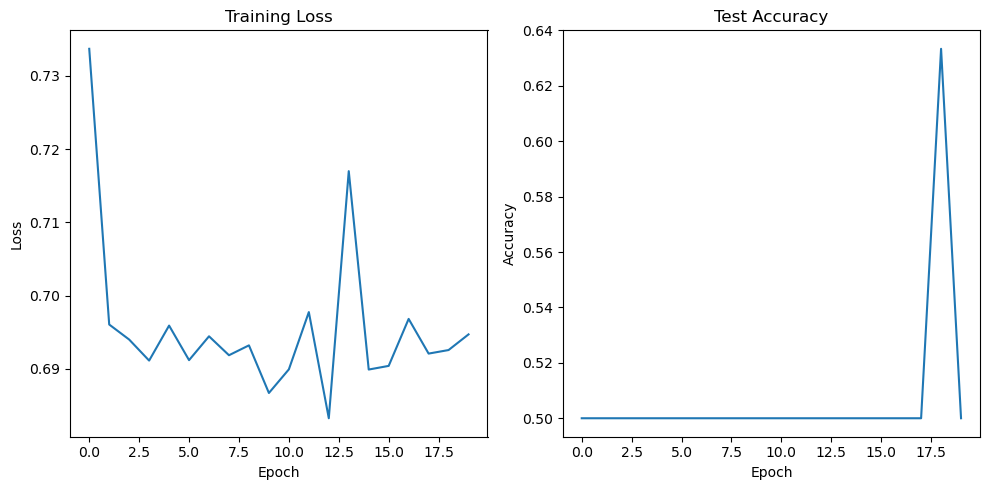

In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
from PIL import Image

# Define directories
train_healthy_spiral = 'C:/Users/iyand/Documents/Project 14/archive/spiral/training/healthy'
train_parkinson_spiral = 'C:/Users/iyand/Documents/Project 14/archive/spiral/training/parkinson'
test_healthy_spiral = 'C:/Users/iyand/Documents/Project 14/archive/spiral/testing/healthy'
test_parkinson_spiral = 'C:/Users/iyand/Documents/Project 14/archive/spiral/testing/parkinson'

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Custom Dataset class
class SpiralDataset(Dataset):
    def __init__(self, healthy_dir, parkinson_dir, transform=None):
        self.healthy_images = [os.path.join(healthy_dir, img) for img in os.listdir(healthy_dir)]
        self.parkinson_images = [os.path.join(parkinson_dir, img) for img in os.listdir(parkinson_dir)]
        self.all_images = self.healthy_images + self.parkinson_images
        self.labels = [0] * len(self.healthy_images) + [1] * len(self.parkinson_images)
        self.transform = transform

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path = self.all_images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets
train_dataset = SpiralDataset(train_healthy_spiral, train_parkinson_spiral, transform=transform)
test_dataset = SpiralDataset(test_healthy_spiral, test_parkinson_spiral, transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN model
class ParkinsonCNN(nn.Module):
    def __init__(self):
        super(ParkinsonCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# ... (rest of your data loading code)

model = ParkinsonCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels.float().unsqueeze(1)).item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    val_loss /= len(test_loader)
    accuracy = correct / total
    
    scheduler.step(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Save the model
torch.save(model.state_dict(), 'parkinson_spiral_model.pth')

# wave Data

In [88]:
####Wave images
train_healthy_wave = 'C:/Users/iyand/Documents/Project 14/archive/wave/training/healthy'
train_parkinson_wave = 'C:/Users/iyand/Documents/Project 14/archive/wave/training/parkinson'
test_healthy_wave = 'C:/Users/iyand/Documents/Project 14/archive/wave/testing/healthy'
test_parkinson_wave = 'C:/Users/iyand/Documents/Project 14/archive/wave/testing/parkinson'